In [1]:
# ## 1. Load and Preprocess Burglary Data

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv', parse_dates=['Month'])

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

print("Raw data overview:")
print(f"Total wards: {burglary_monthly['Ward Code'].nunique()}")
print(f"Time range: {burglary_monthly['Month'].min()} to {burglary_monthly['Month'].max()}")

burglary_monthly

C:\Users\gusta\AppData\Local\Temp\ipykernel_21916\1084114162.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  burglary = pd.read_csv('data/residential_burglary.csv', parse_dates=['Month'])


Raw data overview:
Total wards: 679
Time range: 2013-12-01 00:00:00 to 2025-02-01 00:00:00


,Ward Code,Month,Count
0,E05009317,2013-12-01,8
1,E05009317,2014-01-01,23
2,E05009317,2014-02-01,12
3,E05009317,2014-03-01,11
4,E05009317,2014-04-01,21
...,...,...,...
89633,E05014119,2024-10-01,1
89634,E05014119,2024-11-01,2
89635,E05014119,2024-12-01,4
89636,E05014119,2025-01-01,3


In [5]:

# Load and prepare car ownership data
cars_df = pd.read_excel('data/housing/cars_or_vans_wards.xlsx', sheet_name='2021')
cars_df['NoCarPct'] = (cars_df['none'] / cars_df['All households']) * 100
static_features = cars_df[['ward code', 'NoCarPct']].rename(columns={'ward code': 'Ward Code'})

# Merge static features with burglary data
burglary_enriched = pd.merge(burglary_monthly, static_features, on='Ward Code', how='inner')

burglary_enriched
# print(f"Wards with available socio-economic data: {burglary_enriched['Ward Code'].nunique()}")

,Ward Code,Month,Count,NoCarPct
0,E05009317,2013-12-01,8,63.214480
1,E05009317,2014-01-01,23,63.214480
2,E05009317,2014-02-01,12,63.214480
3,E05009317,2014-03-01,11,63.214480
4,E05009317,2014-04-01,21,63.214480
...,...,...,...,...
89633,E05014119,2024-10-01,1,42.479547
89634,E05014119,2024-11-01,2,42.479547
89635,E05014119,2024-12-01,4,42.479547
89636,E05014119,2025-01-01,3,42.479547


In [12]:
## 4. Modified SARIMAX Implementation with Exogenous Variables

import warnings

# warnings.filterwarnings("ignore")

# Set manual orders for all wards
UNIVERSAL_ORDER = (3, 1, 1)
SEASONAL_ORDER = (3, 1, 1, 12)  # Monthly seasonality
TEST_MONTHS = 26

def analyze_ward_exog(args):
    """Process a ward with SARIMAX and exogenous features"""
    ward_code, ward_df = args
    try:
        # Filter wards with sufficient history
        if len(ward_df) < TEST_MONTHS * 2:
            print(f"{ward_code} has less than {TEST_MONTHS} months data")
            return None

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            ward_df.ffill(inplace=True)

        # Prepare data with exogenous variable
        ward_df = ward_df.set_index('Month').asfreq('MS')
        exog = ward_df[['NoCarPct']]  # Static feature repeated for all time points

        # Ensure exog does not contain NaN or infinite values
        if exog.isnull().values.any() or np.isinf(exog.values).any():
            print(f"{ward_code} has NaN or infinite values in exog")
            # Fill NaN or infinite values with the previous valid value
            exog.replace([np.inf, -np.inf], np.nan, inplace=True)
            exog.ffill(inplace=True)

        # Split data (keep exogenous aligned)
        train = ward_df.iloc[:-TEST_MONTHS]
        test = ward_df.iloc[-TEST_MONTHS:]
        exog_train = exog.iloc[:-TEST_MONTHS]
        exog_test = exog.iloc[-TEST_MONTHS:]

        # Fit pure SARIMAX model:
        model = SARIMAX(train['Count'],
                        order=UNIVERSAL_ORDER,
                        seasonal_order=SEASONAL_ORDER,
                        enforce_stationarity=True,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        # Fit SARIMAX with exogenous variable
        expog_model = SARIMAX(train['Count'],
                        exog=exog_train,
                        order=UNIVERSAL_ORDER,
                        seasonal_order=SEASONAL_ORDER,
                        enforce_stationarity=True,
                        enforce_invertibility=False)
        results_expog = expog_model.fit(disp=False)

        # Forecast with future exogenous values
        forecast = results.get_forecast(steps=TEST_MONTHS)
        forecast_expog = results_expog.get_forecast(steps=TEST_MONTHS, exog=exog_test)

        print(f"{ward_code} completed")

        return {
            'ward_code': ward_code,
            'model': results,
            'actual': test['Count'].values,
            'predicted': forecast.predicted_mean.values,
            'expog_predicted': forecast_expog.predicted_mean.values,
            'exog_coef': results_expog.params['NoCarPct'],  # Store feature coefficient
            'conf_int': forecast.conf_int().values,
            'conf_int_exog': forecast_expog.conf_int().values
        }
    except Exception as e:
        print(f"Error processing {ward_code}: {str(e)}")
        return None

# Process all wards
exog_results = []
for ward_code, group in burglary_enriched.groupby('Ward Code'):
    analysis = analyze_ward_exog((ward_code, group))
    if analysis:
        exog_results.append(analysis)

# warnings.filterwarnings("default")

E05009317 completed
E05009318 completed
E05009319 completed
E05009320 completed
E05009321 has NaN or infinite values in exog
E05009321 completed
E05009322 completed
Error processing E05009323: LU decomposition error.
E05009324 has NaN or infinite values in exog
E05009324 completed
E05009325 completed
E05009326 has NaN or infinite values in exog
E05009326 completed
E05009327 completed
E05009328 has NaN or infinite values in exog
E05009328 completed
E05009329 completed
E05009330 completed
E05009331 completed
E05009332 completed
E05009333 completed
E05009334 completed
E05009335 completed
E05009336 completed
E05009367 has NaN or infinite values in exog
E05009367 completed
E05009368 has NaN or infinite values in exog
Error processing E05009368: LU decomposition error.
E05009369 completed
E05009370 completed
E05009371 completed
E05009372 completed
E05009373 completed
E05009374 completed
E05009375 completed
E05009376 completed
E05009377 completed
E05009378 completed
E05009379 completed
E05009

In [14]:
# 4. Performance Comparison Analysis

def calculate_metrics(actual, pred):
    """Calculate key performance metrics"""
    return {
        'mae': mean_absolute_error(actual, pred),
        'rmse': np.sqrt(mean_squared_error(actual, pred)),
        'mape': np.mean(np.abs((actual - pred) / actual)) * 100
    }

# Calculate metrics for both models, ensuring no NaN values
comparison_results = []
for res in exog_results:
    if np.isnan(res['actual']).any() or np.isnan(res['predicted']).any() or np.isnan(res['expog_predicted']).any():
        print(f"Skipping ward {res['ward_code']} due to NaN values")
        continue  # Skip this ward

    base_metrics = calculate_metrics(res['actual'], res['predicted'])
    exog_metrics = calculate_metrics(res['actual'], res['expog_predicted'])

    comparison_results.append({
        'ward': res['ward_code'],
        'base_mae': base_metrics['mae'],
        'exog_mae': exog_metrics['mae'],
        'base_rmse': base_metrics['rmse'],
        'exog_rmse': exog_metrics['rmse'],
        'mae_improvement': base_metrics['mae'] - exog_metrics['mae'],
        'rmse_improvement': base_metrics['rmse'] - exog_metrics['rmse'],
        'exog_coef': res['exog_coef']
    })

comp_df = pd.DataFrame(comparison_results)


Skipping ward E05009321 due to NaN values
Skipping ward E05009324 due to NaN values
Skipping ward E05009326 due to NaN values
Skipping ward E05009328 due to NaN values
Skipping ward E05009384 due to NaN values
Skipping ward E05009388 due to NaN values
Skipping ward E05009391 due to NaN values
Skipping ward E05009399 due to NaN values
Skipping ward E05009400 due to NaN values
Skipping ward E05009401 due to NaN values
Skipping ward E05009404 due to NaN values
Skipping ward E05011097 due to NaN values
Skipping ward E05011114 due to NaN values
Skipping ward E05011117 due to NaN values
Skipping ward E05011217 due to NaN values
Skipping ward E05011219 due to NaN values
Skipping ward E05011220 due to NaN values
Skipping ward E05011221 due to NaN values
Skipping ward E05011222 due to NaN values
Skipping ward E05011224 due to NaN values
Skipping ward E05011227 due to NaN values
Skipping ward E05011228 due to NaN values
Skipping ward E05011229 due to NaN values
Skipping ward E05011230 due to NaN

In [15]:
# ## 5. Statistical Validation

print("\nOverall Performance Comparison:")
print(f"Average MAE Improvement: {comp_df['mae_improvement'].mean():.2f}")
print(f"Average RMSE Improvement: {comp_df['rmse_improvement'].mean():.2f}")
print(f"Percentage of Wards with Improvement: {np.mean(comp_df['mae_improvement'] > 0)*100:.1f}%")

# Statistical significance test
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(comp_df['base_mae'], comp_df['exog_mae'])
print(f"\nPaired t-test Results (MAE): t={t_stat:.2f}, p={p_value:.4f}")


Overall Performance Comparison:
Average MAE Improvement: -0.00
Average RMSE Improvement: -0.00
Percentage of Wards with Improvement: 50.2%

Paired t-test Results (MAE): t=-1.45, p=0.1468


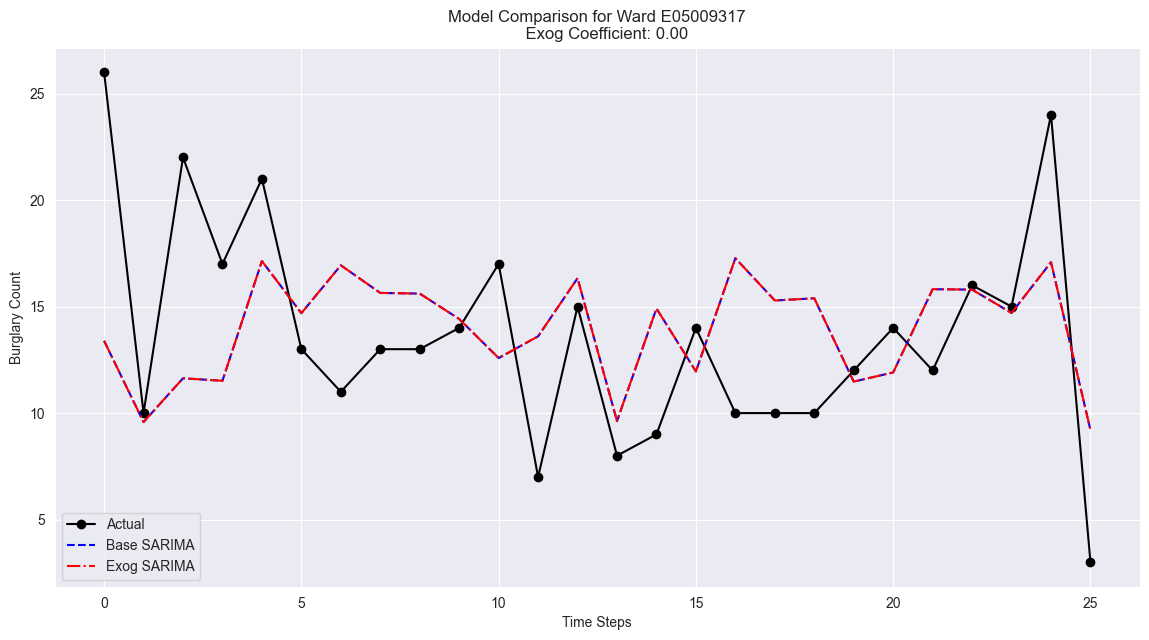

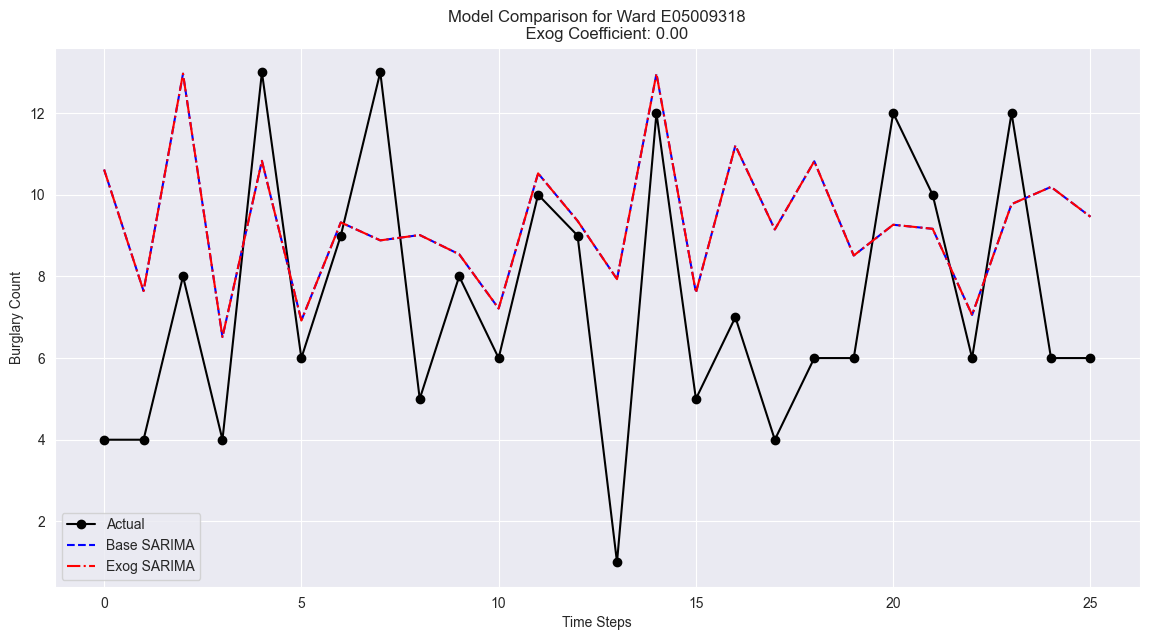

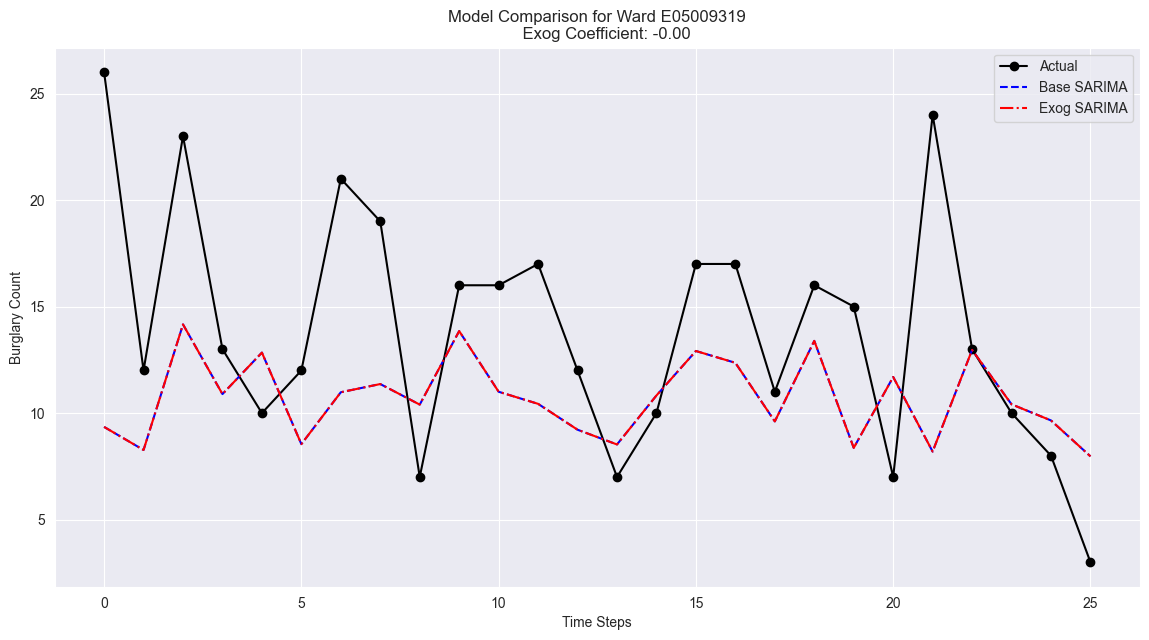

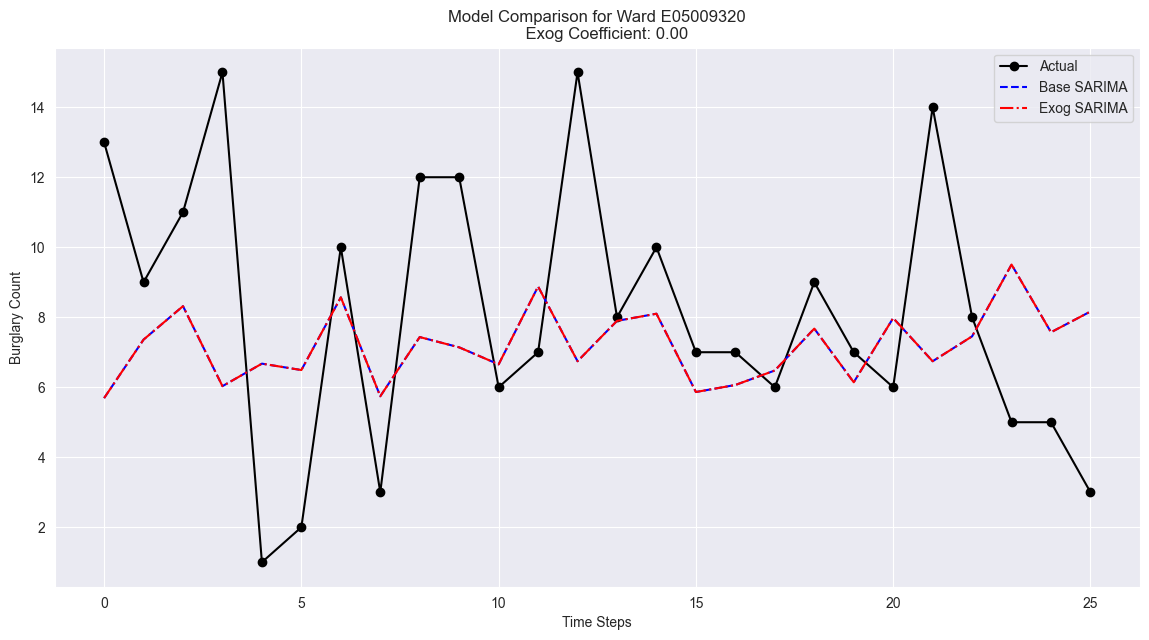

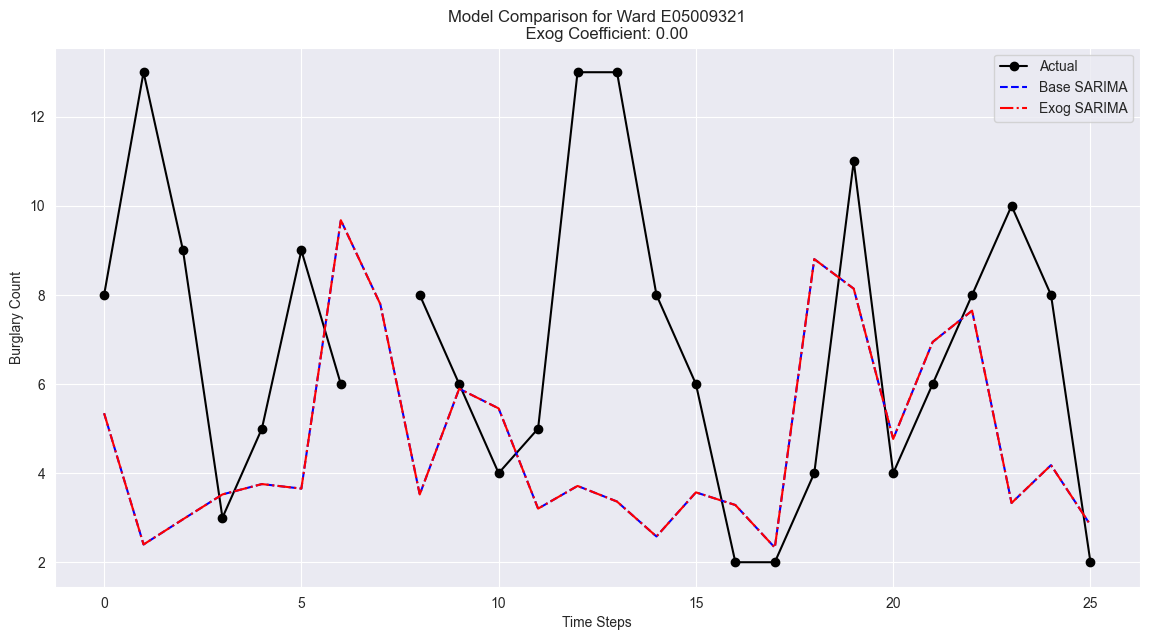

In [16]:
# ## 6. Visualization Suite

def plot_model_comparison(result):
    """Visual comparison of both models' predictions"""
    plt.figure(figsize=(14, 7))

    # Create time axis
    time_steps = np.arange(len(result['actual']))

    # Plot actual vs predictions
    plt.plot(time_steps, result['actual'], 'ko-', label='Actual')
    plt.plot(time_steps, result['predicted'], 'b--', label='Base SARIMA')
    plt.plot(time_steps, result['expog_predicted'], 'r-.', label='Exog SARIMA')

    # Formatting
    plt.title(f'''Model Comparison for Ward {result['ward_code']}
    Exog Coefficient: {result['exog_coef']:.2f}''')
    plt.xlabel('Time Steps')
    plt.ylabel('Burglary Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot first 5 wards
for res in exog_results[:5]:
    plot_model_comparison(res)